# HOG Detection using Python and OpenCV

This is a lab on HOG Detection (a Classical Techniques for Object Classification/Detection) in CE6003. You should complete the tasks in this lab as part of the  Histogram of Oriented Gradients section of the lesson.

Please remember the lab must be completed before taking the quiz at the end of this lesson.

This lab will give some visual intuition on how the HOG classical object classification techniques work. 

We are going to look at Histogram of Oriented Gradients (HOG) algorithm from the perspective of performing inference only, not training. That is, we'll take pre-trained classifiers in both cases, and use them to classify images of various types.

Implementing HOG from scratch is outside the scope of this course, but we will look at how it works and leverage OpenCV's implementation for some practical demonstrations.

First, some setup...

First, if we haven't already done so, we need to clone the various images and resources needed to run these labs into our workspace.

In [1]:
!git clone https://github.com/EmdaloTechnologies/CE6003.git

Cloning into 'CE6003'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 593 (delta 1), reused 1 (delta 0), pack-reused 587
Receiving objects: 100% (593/593), 961.98 MiB | 36.38 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Checking out files: 100% (525/525), done.


And now we'll load various Python libraries that we'll need later in this lab...

In [0]:
import numpy as np
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import urllib
 
def url_to_image(url):
	resp = urllib.request.urlopen(url)
	image = np.asarray(bytearray(resp.read()), dtype="uint8")
	image = cv2.imdecode(image, cv2.IMREAD_COLOR)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
	# return the image
	return image

The calls to method `detectMultiScale()` on the cascade objects do the work. `detectMultiScale()` takes three parameters of 
interest, plus some optional parameters that we'll ignore for this exercise.
The three parameters of interest are:
    
* **image**: the image matrix itself.
* **scale**: the scale stride value, indicating how much to resize the features after each run of the detector. 
* **minNeighbors**: a minimum neighbors field, which specifies how many neighbors each candidate detection should have to retain it. 
        
We are using default values of 1.03 for `scale`, and 2 for `minNeighbors`.

Try playing with these parameters yourself in the code above. For example, set `minNeighbors` to 1, 5, 10, and 100 respectively, rerun the code blocks above related to the Viola-Jones algorithm compare the difference in detections.


Both the scale and minimum neighbors parameters will affect the quality of the detection. Smaller scale values will cause the detector to check more scalings of the features against the image patch, but will increase the processing time. Likewise, larger values will cause fewer scalings which may result in loss of detections, but will run faster.

Setting minimum neighbors to a lower value will ensure that recall is good (no missed detections) but is likely to have many false positives. Setting minNeighbors to a higher value will improve precision (fewer false positives) but will degrade recall - i.e., there may be false negatives.

# Histogram of Oriented Gradients

The Histogram of Oriented Gradients (HOG) algorithm was a significant improvement over the state of the art when it was introduced in 2005 for pedestrian detection by Navneet Dalal and Bill Triggs. Variants of it continued in widespread until approximately 2012 when AlexNet dramatically improved the state of the art for image classification.

A *Histogram of Oriented Gradients* (HOG) is a feature descriptor used in a variety of computer vision and image processing applications, for the purposes of object detection.  The use of HOG descriptors has been a particularly successful technique in detecting, among other things, humans, animals, faces, and text.  

For example, an object detection system can be configured to generate HOG descriptors that describe features of objects in an input image.  The system can also be configured to compare the generated HOG descriptors against a database of HOG descriptors, corresponding to known objects, to determine whether any of the known objects is present in the input image.  

The reasons that HOG is used in these applications are that:

 * it offers robust detection of the object of interest in the presence of small amounts of rotation;
 * through the use of the image pyramid, it works for detecting objects at different scales;
 * thanks to some normalization within the construction of the feature descriptor itself, it works with variations in terms of lighting conditions etc.; and 
 * it generates a compact reference descriptor to be used to describe an object template for comparison with (HOG descriptors computed from) an incoming video-stream from a camera or other device.

Here are three related images that show HOG in operation: (a) the first is an image of a person (sample from the Inria training set), (b) the second is a visualization of that image when turned into HOG gradients and magnitudes (edges and strength of edges), and (c) the third is a visualization of the individual gradients normalized within each block, which improves the end classification score:


| ![](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab3/inria_pedestrian.png?raw=1) | ![](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab3/inria_pedestrian_hog_normalized.png?raw=1) | ![](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab3/inria_pedestrian_hog.png?raw=1) |
|---------------------------|------------------------------------------|-------------------------------|
| (a) Pedestrian Image      | (b) HOG Gradients / Magnitudes           | (c) HOG Normalized per Block  |

The original image above is from the INRIA person database. 


## HOG Workflow

The general steps required to compute a HOG descriptor and convert to a classification score is called the "HOG Pipeline", as shown below.

![HOG Pipeline](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab3/HOG_Pipeline.png?raw=1 "HOG Pipeline")

The pipeline consists of the following steps:

 * **Gradient computation**:  A 1-D centred, point discrete derivative mask is applied in one or both of the horizontal and vertical directions, multiplying color or intensity data of image with the following filter kernels: [-1,0,1] and [-1,0,1]T .
 * **Orientation binning**: Bin pixel vote-weights into 9 histogram bins (covering 0 to 180 or 0 to 360 degrees). The weight, or pixel contribution, can either be the gradient magnitude itself, or some function of the magnitude; in actual tests the gradient magnitude itself generally produces the best results. Other options for the weight could include the square root or square of the gradient magnitude, or some clipped version of the magnitude.
 * **Descriptor blocks**: To account for changes in illumination and contrast, gradient strengths are locally normalized, by grouping cells  together into larger, spatially connected blocks. The HOG descriptor is then the vector of the components of the normalized cell histograms from all of the block regions. These blocks typically overlap, meaning that each cell contributes more than once to the final descriptor. Two main block geometries exist: rectangular R-HOG blocks and circular C-HOG blocks.  R-HOG blocks are generally square grids, represented by three parameters: the number of cells per block, the number of pixels per cell, and the number of channels per cell histogram and R-HOG blocks appear quite similar to the SIFT descriptors.  There is a minor improvement in performance by applying a Gaussian spatial window within each block before tabulating histogram votes.
 * **Block normalization**: there are a number of different algorithms typically applied to normalize histograms at the block level, including L2-norm, L2-Hysteresis, L1-Square Root, and L1-norm.
 * **Classifier** : The descriptors are finally fed into a recognition system based on a pre-trained classifier, most commonly a Support Vector Machine (SVM).
 
The entire process is illustrated as follows:

![HOG Feature Descriptor](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab3/HOG_Feature_Descriptor.png?raw=1 "HOG Feature Descriptor")

This HOG computation is traditionally performed by repeatedly stepping a window of, say, 64 pixels wide by 128 pixels high across a source image frame and computing the HOG descriptor as outlined in the previous section. As the HOG calculation contains no intrinsic sense of scale and objects can occur at multiple scales within an image, the HOG calculation is stepped and repeated across each level of a scale pyramid. The scaling factor between each level in the scale pyramid is commonly between 1.05 and 1.2 and the image is repeatedly down-scaled until the scaled source frame can no longer accommodate a complete HOG window as shown below.  

| ![HOG Image Pyramid](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab3/HOG_Image_Pyramid.png?raw=1 "HOG Image Pyramid") | ![Pyramid Scanning](https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab3/Pyramid_Scanning.gif?raw=1 "Pyramid Scanning") |
|-----------------------------------------------------------------|----------------------------------------------------------------|
| HOG Image Pyramid                                               | Sliding Across Feature Descriptor then Resizing Image           |

Coarse spatial sampling, fine orientation sampling, and strong local photometric normalization permits the individual body movement of pedestrians to be ignored to a degree, so long as they maintain a roughly upright position.

### HOG Training

The first step of training is the creation, or acquisition, of a dataset, which consists of a number of positive and negative training example images.  Positive images are examples that contain the object we want to detect.  Ideally, the positives contain objects of approximately the same size and in approximately the center of the image, and across different illumination contexts, backgrounds, etc.  Partial occlusions may also be present in the positive training sub-set. Positive examples need to have the same dimensions as the feature detector.

The negative training set can be any images that do not contain the object we want to detect. In this respect, negative source images can be of any size, and patches the same size as the feature detector can be randomly sub-sampled across these images in spatial and scale space.

A commonly used training set for pedestrians is the INRIA Person Database, used by Dalal and Triggers for the original HOG implementation.  It can be downloaded from http://pascal.inrialpes.fr/data/human/. It consists of positive images in normalized 64x128 format, and negative images of larger sizes for sub-sampling. 

Typically, a portion of the dataset is reserved for testing the performance of the classifier afterwards – for example 10-20%.

![HOG Training Flow](images/lab3/hog_training_flow.png "HOG Training Flow")

The training process consists of the following steps, as illustrated above:

 * Generate a random set of negatives from the negative training images, across spatial and scale space. With the INRIA Person Database, for example, a set of 12180 examples (10 per negative image) might be randomly sampled.
 * Positive and negative source images are converted to HOG block descriptors.
 * These block descriptors are concatenated, converted into the input format for the SVM trainer and labelled appropriately as positive or negative.
 * The SVM trainer selects the best hyperplane to separate positive and negative examples from the training set, and an initial set of weights and a bias term are output.  As an example, the LIBSVM project (https://github.com/cjlin1/libsvm) includes a suitable trainer (svm-train) for learning and outputting this hyperplane.
 * The trainer typically outputs a set of “support vectors” (s) – that is, examples from the training set which best describe the hyperplane. The hyperplane is the learned decision boundary separating positive examples from negative examples. Each of these support vector includes a scale factor ("alpha", α).  
 * To calculate the hyperplane vector, v<sub>hyper</sub>, each support vector is scaled by its individual scaling factor, and the mean of this scaled set of support vectors is determined.
 
$$V_{hyper}=\ 1/n\sum_{i=1}^{n}{\alpha_i\ (s_i)}$$

Finally, the complete set of negatives in the training dataset is exhaustively searched for false positives – i.e. with those initial weights/bias, examples with a classification score greater than zero.  These negatives are added in as hard negatives to the training data, and training repeated. This process is called ‘boosting’ or ‘bootstrapping’.  Typically, 2-3 rounds of boosting are required to reach full performance.




First, we are going to read in a test image into a variable called `img`. Feel free to experiment with changing this to a different URL pointing to an image of people.

In [0]:
# read in test image (from Microsoft COCO database)
#img = cv2.imread("/content/CE6003/images/lab3/000000002701.jpg")
img = url_to_image("https://github.com/EmdaloTechnologies/CE6003/blob/master/images/lab3/000000002701.jpg?raw=1")

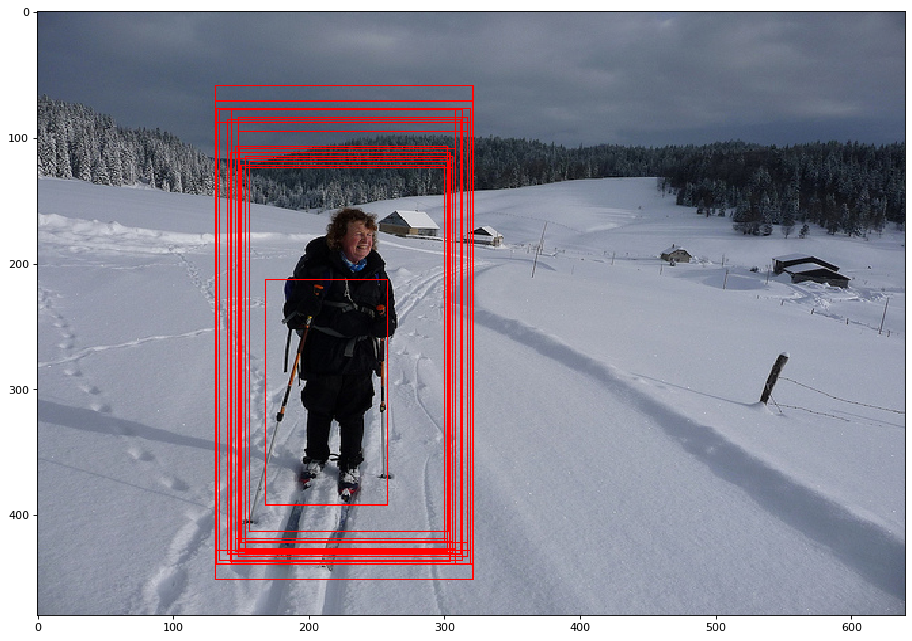

In [7]:

# create HOG descriptor using default people (pedestrian) detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# run detection, using a spatial stride of 4 pixels (horizontal and verticle), a scale stride of 1.02, and zero grouping of
# rectangles (to demonstrate that HOG will detect at potentially multiple places in the scale pyramid)
(foundBoundingBoxes, weights) = hog.detectMultiScale(img, winStride=(4, 4), padding=(8, 8), scale=1.02, finalThreshold=0)

# we're going to copy the original test image to draw bounding boxes on it for now, as we'll use it again later
redColor = (255, 0, 0)
lineThickness = 1
imgWithRawBboxes = img.copy()
for (hx, hy, hw, hh) in foundBoundingBoxes:
        cv2.rectangle(imgWithRawBboxes, (hx, hy), (hx + hw, hy + hh), redColor, lineThickness)
        
plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(imgWithRawBboxes, aspect='auto') 
plt.show()


This illustrates some interesting properties and problems with HOG - you can see many extraneous detections which need to be fused together using non maximal suppression (NMS). Additionally, you can see many incorrect detections where the HOG algorithm incorrectly classified pedestrians.

We'll use the Python library `imutils` to perform NMS for us.

Before suppression, we had 19 bounding boxes, after suppression we have 1


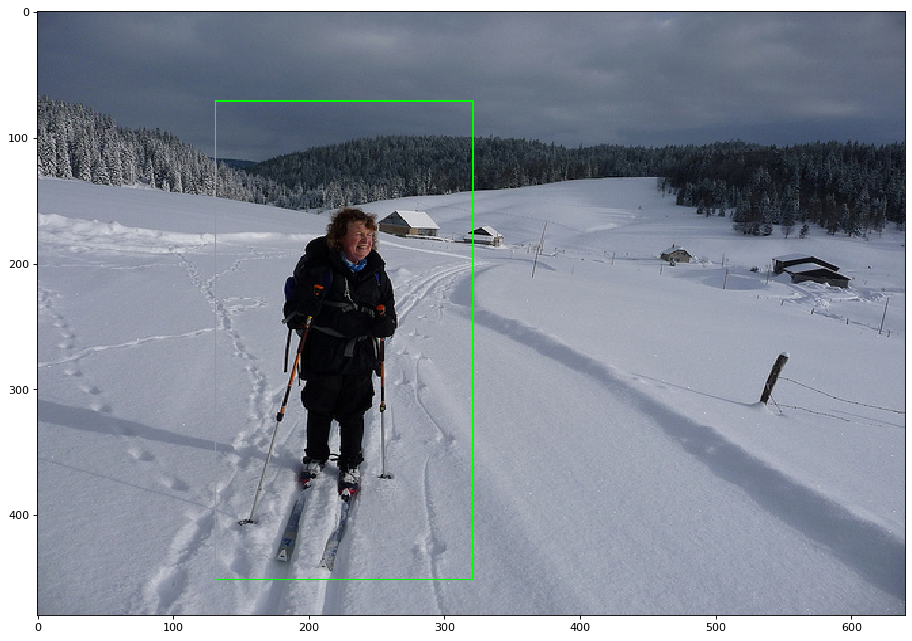

In [9]:
from imutils.object_detection import non_max_suppression

# convert our bounding boxes from format (x1, y1, w, h) to (x1, y1, x2, y2)
rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in foundBoundingBoxes])

# run non-max suppression on these based on an overlay op 65%
nmsBoundingBoxes = non_max_suppression(rects, probs=None, overlapThresh=0.65)

print ("Before suppression, we had {} bounding boxes, after suppression we have {}".format(len(rects), len(nmsBoundingBoxes)))

greenColor = (0, 255, 0)
lineThickness = 1
# draw the final bounding boxes
for (xA, yA, xB, yB) in nmsBoundingBoxes:
    cv2.rectangle(img, (xA, yA), (xB, yB), greenColor, lineThickness)

# and show our work
plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(img, aspect='auto') 
plt.show()


Using the extra stage of non-maximal suppression on bounding boxes (based on percentage overlap), 
we have manage to consolidate our detections into a single reasonable detection...

# Conclusions

In this lab, we have seen an example of traditional object classification/detection systems, using hand-crafted features with shallow learning algorithms.  We have learned about the image pyramid, and why it is sometimes needed to detect objects at different scales. We have also seen the need for non-maximal suppression of results during object detection.

Compared to Viola Jones, HOG is a more accurate detector. Its hand-crafted features detect gradients and gradient magnitudes for blocks of pixels, which is uses to learn characteristic sets of edges for a particular object detector.  However, it can be slow and often requires the use of a full image pyramid to perform detections at different scales.

For many years after its introduction, HOG and its derivative models represented the state of the art in object detection in terms of accuracy.

Over time, researchers incrementally improved the speed of HOG through caching, and the clever adoption of Haar ideas such as cascades of fast rejectors and scaling features not images. Others attempt to add higher semantic layers to HOG by breaking objects into constituent parts (*deformable parts models*) which had hand-crafted spatial relationships with each other. For example, for people detectors, this could include breaking up the person into a head, torso, arms and legs.

When CNNs were (re-)introduced to the problem of image classification with AlexNet in 2012, they were significantly more accurate than the best previous hand-crafted feature detector at the time, and they have continued improving at a faster rate.

In later labs, we'll take a look at state of the art deep neural networks for image classification.  We will also discuss the techniques deep nets are currently using to avoid requiring to scan the entire image pyramid, as we do above with the HOG example.
